In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from arch import arch_model
from arch.univariate import ConstantMean
import mgarch
from datetime import date

In [3]:
Bank_data = pd.read_csv("Bank_data_full_2.csv")
Bank_data = Bank_data.drop(['PERMNO','PERMCO'], axis = 1)

Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
Bank_data_other = Bank_data_other.drop(['PERMNO','PERMCO'], axis = 1)



SP_index = pd.read_csv("SP_500_Data.csv")
sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")
sector_data = sector_data.rename(columns={sector_data.columns[0]:'Date'})
sector_data.head()

sector_data.iloc[:, 0] = pd.to_datetime(sector_data.iloc[:, 0].astype(str), format='%Y%m%d', errors='coerce')

sector_data = sector_data[['Date','Aero', 'Guns', 'Ships','Oil', 'Coal', 'Util']].copy()

sector_data = sector_data.loc[:26132]




C:\Users\Coco\AppData\Local\Temp\ipykernel_12708\2074775263.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data = pd.read_csv("Bank_data_full_2.csv")
C:\Users\Coco\AppData\Local\Temp\ipykernel_12708\2074775263.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Bank_data_other = pd.read_csv("Bank_data_full_2.csv")
C:\Users\Coco\AppData\Local\Temp\ipykernel_12708\2074775263.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sector_data = pd.read_csv("48_Industry_Portfolios_Daily.csv")


In [4]:
Bank_data_other['Market_Cap'] = Bank_data_other['PRC'].values*Bank_data_other['SHROUT'].values


In [5]:
sector_data.set_index('Date', inplace=True)

c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [6]:
sector_data = sector_data.sort_index()
sector_data = sector_data[ (sector_data.index >= '2000-01-03') & (sector_data.index <= '2024-12-31') ].copy()


In [7]:

SP_index = SP_index.rename(columns={'caldt':'Date','sprtrn': 'Ret'})

SP_index.set_index('Date', inplace=True)

In [8]:
SP_index = SP_index.sort_index()

SP_index = SP_index[ (SP_index.index >= '2000-01-03') & (SP_index.index <= '2024-12-31') ].copy()

In [9]:
sector_data = sector_data.apply(pd.to_numeric, errors='coerce')

In [10]:
Defence_index = pd.DataFrame()
Energy_index = pd.DataFrame()

Defence_index = 1/3*sector_data['Aero'].values+1/3*sector_data['Guns'].values+1/3*sector_data['Ships'].values
Energy_index = 1/3*sector_data['Oil'].values+1/3*sector_data['Coal'].values+1/3*sector_data['Util'].values

In [11]:
Defence_index  = pd.DataFrame(Defence_index, index = sector_data.index)

Energy_index = pd.DataFrame(Energy_index,index=sector_data.index)

Defence_index = Defence_index
Energy_index = Energy_index
Energy_index.head()

,0
Date,
2000-01-03,-0.773333
2000-01-04,-2.586667
2000-01-05,1.183333
2000-01-06,0.460000
2000-01-07,1.623333


In [12]:
SP_index.columns

Index(['Ret'], dtype='object')

In [13]:
Geo_Pol_long = pd.DataFrame()
Geo_Pol_short = pd.DataFrame()
Geo_Pol_index = pd.DataFrame()

Geo_Pol_long = 0.5*Defence_index.values+0.5*Energy_index.values # in percentage
Geo_Pol_long = pd.DataFrame(Geo_Pol_long, index = Energy_index.index)

Geo_Pol_short = -SP_index.values*100 # from decimal to percentage


In [14]:
Geo_Pol_index = Geo_Pol_long+Geo_Pol_short


In [15]:
Bank_data['date'] = pd.to_datetime(Bank_data['date'])
Bank_data.set_index('date', inplace=True)

In [16]:
Bank_data_other['date'] = pd.to_datetime(Bank_data_other['date'])
Bank_data_other.set_index('date', inplace=True)

In [17]:
Bank_data= Bank_data.sort_index()

Bank_data = Bank_data[ (Bank_data.index >= '2000-01-03') & (Bank_data.index <= '2024-12-31') ].copy()

In [18]:
Bank_data_other = Bank_data_other.sort_index()

Bank_data_other = Bank_data_other[ (Bank_data_other.index >= '2000-01-03') & (Bank_data_other.index <= '2024-12-31') ].copy()

In [19]:

Bank_data = {ticker: group for ticker, group in Bank_data.groupby('TICKER')}

In [20]:

Bank_data_other = {ticker: group for ticker, group in Bank_data_other.groupby('TICKER')}


In [21]:
X = np.column_stack([SP_index.values, Geo_Pol_index.values])
X = sm.add_constant(X)


results = {}




In [22]:
for ticker,y in Bank_data.items():

    if len(y)==len(SP_index):

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results[ticker] = model





In [23]:
market_caps = [np.mean(y['Market_Cap']) for y in Bank_data_other.values()]
threshold = np.percentile(market_caps, 90)
print("Market Cap threshold for top 10% banks:", threshold)

Market Cap threshold for top 10% banks: 4651892.915935034


In [24]:
results_other = {}
for ticker,y in Bank_data_other.items():


    if len(y)==len(SP_index)and np.mean(y['Market_Cap'])>threshold:

        ys = y['RET'].astype(float).values
        X_ = X.astype(float)
        model = sm.OLS(ys, X).fit()
        results_other[ticker] = model





In [25]:
neg_x2 = {}

x2_idx = 2
for ticker, model in results.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval,
            'results': model.summary()
        }

for ticker, vals in neg_x2.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'],'\n', vals['results'])

In [26]:
neg_x2_other = {}

for ticker, model in results_other.items():

    x2_coef = model.params[x2_idx]
    x2_tval = model.tvalues[x2_idx]

    if x2_coef < 0 and np.abs(x2_tval) > 2 :
        neg_x2_other[ticker] = {
            'x2_coef': x2_coef,
            'x2_tvalue': x2_tval
        }

for ticker, vals in neg_x2_other.items():
    print(ticker, vals['x2_coef'], vals['x2_tvalue'])

# Prepare Exog neg returns Indicator 

In [27]:
r_minus = [i if i < 0 else 0 for i in SP_index['Ret']]


In [28]:
len(r_minus)

6289

In [29]:
print(r_minus)

[-0.009549, -0.038345, 0, 0, 0, 0, -0.013063, -0.004386, 0, 0, -0.006832, 0, -0.007095, -0.002912, -0.027634, 0, -0.004213, -0.003938, -0.027457, 0, 0, -0.000114, 0, -0.000421, -9.1e-05, 0, -0.020822, 0, -0.020969, 0, 0, -0.010256, 0, -0.030376, 0, 0, -0.005336, -0.014829, 0, 0, 0, 0, 0, -0.012695, -0.025631, 0, 0, -0.004723, -0.008207, -0.017685, 0, 0, 0, -0.005353, 0, 0, 0, 0, -0.002357, -0.010585, 0, -0.013656, 0, 0, -0.007464, -0.004924, 0, 0, -0.007841, -0.002572, -0.022271, -0.018171, -0.058278, 0, 0, -0.009808, 0, -0.003262, 0, -0.011134, 0, -0.008526, 0, -0.014957, -0.021566, -0.003908, 0, -0.005905, -0.008447, -0.0206, 0, 0, 0, 0, -0.012442, -0.007315, -0.021055, -0.004428, -0.019176, 0, -0.01253, -0.002533, 0, -0.001301, 0, 0, -0.006519, -0.006671, 0, -0.006586, -0.003229, -0.007516, 0, 0, 0, -0.00965, 0, -0.006763, 0, -0.01822, -0.007368, 0, -0.003271, 0, -0.008544, 0, 0, -0.015862, 0, 0, -0.002218, 0, 0, 0, 0, 0, -0.011089, -0.007886, 0, -0.010284, -0.010742, 0, -0.014955, 

# Prepare GPR index from monthly data (test instead of current index)

In [30]:
# create gpr_t_index_monthly by taking only the month columnn and GPRT column from gpr_data
gpr_data['Date'] = pd.to_datetime(gpr_data['month'], format='%d/%m/%Y')
gpr_t_index_monthly = gpr_data[['Date', 'GPRT']].copy()
gpr_t_index_monthly.set_index('Date', inplace=True)

NameError: name 'gpr_data' is not defined

In [ ]:
gpr_t_index_monthly = gpr_t_index_monthly[
    (gpr_t_index_monthly.index >= '1999-12-01') & 
    (gpr_t_index_monthly.index <= '2010-01-31')    
]

In [ ]:
# interpolate monthly data to daily data 
gpr_t_index_daily = gpr_t_index_monthly.resample('D').ffill()

In [ ]:
# match gpr dates to SP_index dates
gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]

/var/folders/0q/vd9_j4p16sxdmvrf02mwf33m0000gn/T/ipykernel_20384/726057541.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gpr_t_index_daily = gpr_t_index_daily.loc[gpr_t_index_daily.index.isin(SP_index.index)]


In [ ]:
gpr_t_index_daily['GPRT_change'] = gpr_t_index_daily['GPRT'].diff().fillna(0)
gpr_t_index_daily.head()

,GPRT,GPRT_change
Date,,
2000-01-03,65.57,0.0
2000-01-04,65.57,0.0
2000-01-05,65.57,0.0
2000-01-06,65.57,0.0
2000-01-07,65.57,0.0


In [ ]:
len(gpr_t_index_daily)

2515

# Prepare log returns + scaling

In [32]:
# scaling 
scale_i = 100  # log(1+r)*10 ≈ r*10
scale_mkt = 1  # S&P 500 return without scaling
scale_r_m = 100 # negative market return *100
# scale_g = 100 


In [33]:
# data prep 

for ticker ,y in Bank_data.items():
    y['RET'] = pd.to_numeric(y['RET'], errors='coerce')
    y['RET'] = y['RET'].interpolate(method='linear', limit=2) 
    y['RET'] = y['RET'].fillna(0.0)
    y['logRET'] = np.log1p((y['RET'].copy()).astype(float).values)
    y['logRET'] = y['logRET']*scale_i
    Bank_data[ticker]['logRET'] = y['logRET']

# GJR-GARCH

In [34]:
x = r_minus.copy()
x = np.array(x) * scale_r_m
x = sm.add_constant(x)

sigma_i = {}
res_i = {} 
z_i = {}

for ticker,y in Bank_data.items():
    if len(y)==len(r_minus):
        ys = y['logRET'].values
        model_i = arch_model(ys,x, vol='Garch', p=1, q=1)
        res_i[ticker] = model_i.fit(disp='off')
        sigma_i[ticker] = res_i[ticker].conditional_volatility
        z_i[ticker] = res_i[ticker].resid / sigma_i[ticker]
        
rm = SP_index['Ret'].values * scale_mkt
model_m = arch_model(rm,x, vol='Garch', p=1, q=1)
res_m = model_m.fit(disp='off')
sigma_m = res_m.conditional_volatility
z_m = res_m.resid / sigma_m

fgeo = Geo_Pol_index.values
# fgeo = np.log(gpr_t_index_daily['GPRT']).diff().fillna(0).values * scale_g # get log diffs
model_geo = arch_model(fgeo, x, vol='Garch', p=1, q=1)
res_geo = model_geo.fit(disp='off')
sigma_geo = res_geo.conditional_volatility
z_geo = res_geo.resid / sigma_geo




c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001492. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [35]:
fgeo

array([[-1.8801    ],
       [ 2.95116667],
       [ 1.52946667],
       ...,
       [ 0.60226667],
       [ 0.97186667],
       [ 0.5485    ]])

# DCC 

In [36]:
def extract_R_t(model, a, b):
    a = a
    b = b
    D_t = model.D_t  # T x N conditional volatilities
    rt = model.rt    # T x N returns (mean-centered)
    T = rt.shape[0]
    N = rt.shape[1]
    
    Q_bar = np.cov(rt.T)  # Long-run correlation
    Q_t = np.zeros((T, N, N))
    R_t = np.zeros((T, N, N))
    
    Q_t[0] = np.matmul(rt[0].T / 2, rt[0] / 2)
    
    for i in range(1, T):
        dts = np.diag(D_t[i])
        dtinv = np.linalg.inv(dts)
        et = dtinv @ rt[i].T  # Standardized residuals
        
        Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
        qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
        
        R_t[i] = qts @ Q_t[i] @ qts  # Normalized correlation
    
    return R_t  # T x N x N array of correlation matrices

In [37]:
for ticker in z_i.keys():
    print(ticker)

ABCB
AXP
BAC
BAP
BCS
BHB
BK
BLX
BMO
BMRC
BOH
BPOP
BUSE
CASS
CATY
CBAN
COF
FBP
FCF
GBCI
IBCP
ING
MTB
MUC
NBN
NTRS
OFG
RY
SBSI
SNV
STT
TD
TMP
TRST
UNTY
USB
VLY
WFC


In [38]:
R_t_dict = {}
models = {}
a_s = []
b_s = []
for ticker in z_i.keys():
    # ticker = 'BAC'
    z_stack = np.column_stack([z_i[ticker], z_m, z_geo])
    mgarch_model = mgarch.mgarch()
    mgarch_model.fit(returns=z_stack)
    a_s.append(mgarch_model.a)
    b_s.append(mgarch_model.b)
    models[ticker] = mgarch_model
a_median = np.median(a_s)
b_median = np.median(b_s)
for ticker in z_i.keys():
# calculate model for all banks to get a,b and get medians to calculate R_t for each bank
    R_t = extract_R_t(models[ticker], a=a_median, b=b_median)
    R_t_dict[ticker] = R_t

c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\mgarch\mgarch.py:56: RuntimeWarning: invalid value encountered in sqrt
  qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))
c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\Coco\AppData\Local\Programs\Python\Python312\Lib\site-packages\mgarch\mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \


KeyboardInterrupt: 

In [ ]:
len(R_t)

2515

In [ ]:
import matplotlib.pyplot as plt

ticker = 'BAC'
R_t = R_t_dict[ticker]

# Assume returns_df was used to compute R_t
dates = y.index  # ← exact trading days used

plt.figure(figsize=(12, 6))

plt.plot(dates, R_t[:, 0, 2], label='BAC – Geo-Political')
plt.plot(dates, R_t[:, 1, 2], label='Market – Geo-Political')

plt.title(f'Time-varying Correlations for {ticker}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'BAC'

In [ ]:
beta_t = {}
ticker = 'BAC'
R = R_t_dict[ticker]
rho_im = R[:, 0, 1]
rho_ig = R[:, 0, 2]
rho_mg = R[:, 1, 2]

T = R.shape[0]

sigma_i_aligned = sigma_i[ticker][-T:]  
sigma_m_aligned = sigma_m[-T:]
sigma_geo_aligned = sigma_geo[-T:]


Sigma_FF = np.zeros((T, 2, 2))
Sigma_FF[:, 0, 0] = sigma_m_aligned**2
Sigma_FF[:, 1, 1] = sigma_geo_aligned**2
Sigma_FF[:, 0, 1] = rho_mg * sigma_m_aligned * sigma_geo_aligned
Sigma_FF[:, 1, 0] = Sigma_FF[:, 0, 1]

Sigma_iF = np.zeros((T, 2))
Sigma_iF[:, 0] = rho_im * sigma_i_aligned * sigma_m_aligned      # Cov(BAC, market)
Sigma_iF[:, 1] = rho_ig * sigma_i_aligned * sigma_geo_aligned    # Cov(BAC, geo)

# Sigma_FF_inv = np.linalg.inv(Sigma_FF)  # (T, 2, 2)

beta_t_BAC = np.zeros((T, 2))
for t in range(T):
    beta_t_BAC[t, :] = np.linalg.solve(Sigma_FF[t], Sigma_iF[t])

beta_t[ticker] = beta_t_BAC

# beta_t['BAC'] = np.matmul(Sigma_FF_inv, Sigma_iF)  # (T, 2, 1)

In [ ]:
# align dates 

dates_aligned = y.index[-T:]
betat_mkt = beta_t_BAC[:, 0]
betat_geo = beta_t_BAC[:, 1]

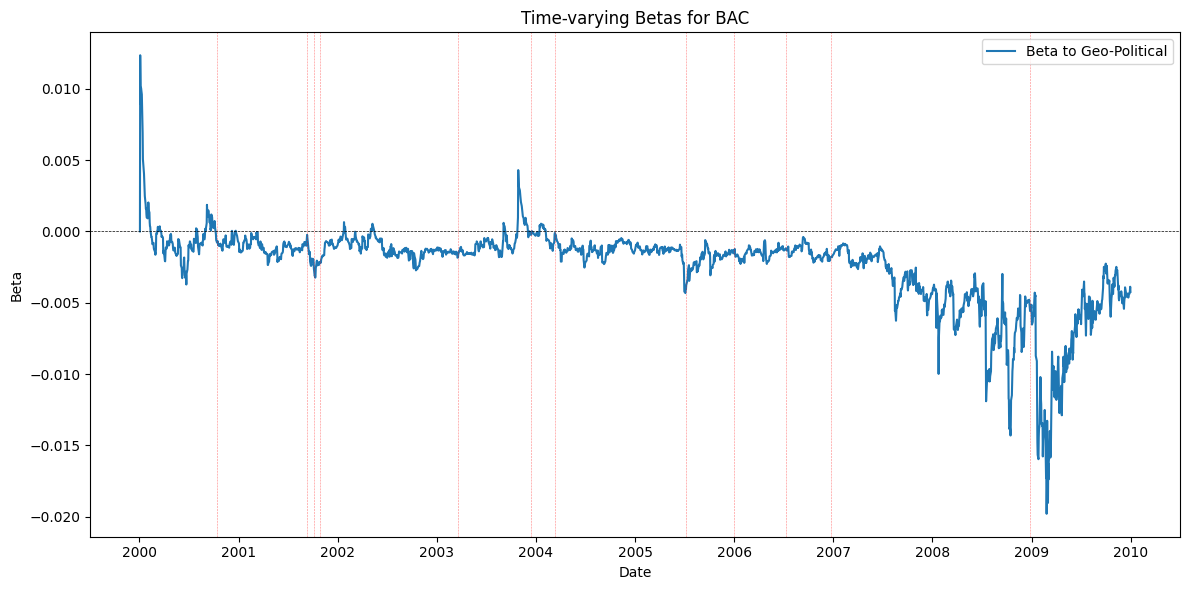

In [ ]:
events = {
    # --- Early 2000s ---
    'USS Cole Bombing': pd.Timestamp('2000-10-12'),

    # --- 9/11 and War on Terror ---
    '9/11 Attacks': pd.Timestamp('2001-09-11'),
    'Afghanistan War Begins': pd.Timestamp('2001-10-07'),
    'Patriot Act Signed': pd.Timestamp('2001-10-26'),

    # --- Middle East conflicts ---
    'Iraq Invasion': pd.Timestamp('2003-03-20'),
    'Capture of Saddam Hussein': pd.Timestamp('2003-12-13'),
    'Madrid Train Bombings': pd.Timestamp('2004-03-11'),

    # --- Terrorism in financial centers ---
    'London Bombings': pd.Timestamp('2005-07-07'),

    # --- Energy & geopolitical tension ---
    'Russia–Ukraine Gas Dispute': pd.Timestamp('2006-01-01'),
    'Israel–Hezbollah War': pd.Timestamp('2006-07-12'),
    'Iran Nuclear Sanctions Escalation': pd.Timestamp('2006-12-23'),

    # --- Late period ---
    'Gaza War': pd.Timestamp('2008-12-27')
}

beta_geo_rescaled = betat_geo / scale_i
plt.figure(figsize=(12, 6))
plt.plot(dates_aligned, beta_geo_rescaled, label='Beta to Geo-Political')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for event, date in events.items():
    plt.axvline(x=date, color='red', linestyle='--', linewidth=0.4, alpha=0.5)
plt.title('Time-varying Betas for BAC')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Diagnostic output
crisis_periods = {
    '9/11': ('2001-09-11', '2001-12-31'),
    'Iraq War': ('2003-03-01', '2003-06-30'),
    'Financial Crisis': ('2008-09-01', '2009-03-31')
}

print("\n=== Beta Diagnostics ===")
for period_name, (start, end) in crisis_periods.items():
    mask = (dates_aligned >= start) & (dates_aligned <= end)
    if mask.sum() > 0:
        avg_beta = betat_geo[mask].mean()
        print(f"{period_name}: Avg Geo Beta = {avg_beta:.4f}")
        print(f"  → {'NEGATIVE (banks suffer)' if avg_beta < 0 else 'POSITIVE'}")


=== Beta Diagnostics ===
9/11: Avg Geo Beta = -0.1602
  → NEGATIVE (banks suffer)
Iraq War: Avg Geo Beta = -0.1344
  → NEGATIVE (banks suffer)
Financial Crisis: Avg Geo Beta = -0.9286
  → NEGATIVE (banks suffer)


In [ ]:
Geo_Pol_index.index = pd.to_datetime(Geo_Pol_index.index)

factor_price = (1 + Geo_Pol_index / 100).cumprod()
six_month_factor_return = factor_price / factor_price.shift(126) - 1

In [ ]:
top_1pct = six_month_factor_return.quantile(0.99)
print("Top 1% 6-month return:", top_1pct)


Top 1% 6-month return: 0    0.471028
Name: 0.99, dtype: float64


In [ ]:
top_1pct_events = six_month_factor_return[six_month_factor_return >= top_1pct].dropna()



# Merge the book data and market data in dictionaries for each firm

In [39]:
Dashboard_data = pd.read_csv("Dashboard_data.csv")

Dashboard_data = Dashboard_data[['tic','datadate','atq','ceqq']]

Dashboard_data['Book Leverage'] = Dashboard_data['atq']-Dashboard_data['ceqq']


In [40]:
dashboard_dict = {}
for tic, group in Dashboard_data.groupby('tic'):
    dashboard_dict[tic] = group.drop(columns='tic').reset_index(drop=True)

In [41]:
dashboard_dict['BAC']

,datadate,atq,ceqq,Book Leverage
0,2000-03-31,656113.0,45222.0,610891.0
1,2000-06-30,679538.0,45786.0,633752.0
2,2000-09-30,671725.0,46785.0,624940.0
3,2000-12-31,642191.0,47556.0,594635.0
4,2001-03-31,609755.0,48815.0,560940.0
...,...,...,...,...
99,2024-12-31,3261519.0,272400.0,2989119.0
100,2025-03-31,3349424.0,275082.0,3074342.0
101,2025-06-30,3441142.0,276104.0,3165038.0
102,2025-09-30,3403716.0,278160.0,3125556.0


In [43]:
Bank_data_other['BAC']

,TICKER,PRC,RET,SHROUT,Market_Cap
date,,,,,
2000-01-03,BAC,48.4375,-0.034869,1707184.0,82691725.0
2000-01-04,BAC,45.5625,-0.059355,1707184.0,77783571.0
2000-01-05,BAC,46.0625,0.010974,1707184.0,78637163.0
2000-01-06,BAC,49.3750,0.071913,1707184.0,84292210.0
2000-01-07,BAC,48.6875,-0.013924,1707184.0,83118521.0
...,...,...,...,...,...
2024-12-24,BAC,44.3800,0.011164,7672880.0,340522414.4
2024-12-26,BAC,44.5500,0.003831,7672880.0,341826804.0
2024-12-27,BAC,44.3400,-0.004714,7672880.0,340215499.2


In [ ]:
# Merge dashboard_dict and Bank_data_other based on matching ticker names
# Strategy: Use daily market data and forward-fill quarterly book data
merged_dict = {}

# Find common tickers between both dictionaries
common_tickers = set(dashboard_dict.keys()).intersection(set(Bank_data_other.keys()))

print(f"Found {len(common_tickers)} common tickers")

for ticker in common_tickers:
    df_dashboard = dashboard_dict[ticker].copy()
    df_bank = Bank_data_other[ticker].copy()
    
    # Ensure both have datetime indices
    if not isinstance(df_dashboard.index, pd.DatetimeIndex):
        df_dashboard['datadate'] = pd.to_datetime(df_dashboard['datadate'])
        df_dashboard.set_index('datadate', inplace=True)
    
    if not isinstance(df_bank.index, pd.DatetimeIndex):
        df_bank.index = pd.to_datetime(df_bank.index)
    
    # Find the latest start date between both dataframes (so we don't need to extrapolate missing data)
    start_dashboard = df_dashboard.index.min()
    start_bank = df_bank.index.min()
    latest_start = max(start_dashboard, start_bank)
    
    # Filter both dataframes to start from the latest start date
    df_dashboard = df_dashboard[df_dashboard.index >= latest_start]
    df_bank = df_bank[df_bank.index >= latest_start]
    
    # Create a dataframe with the daily index from Bank_data_other
    merged_df = df_bank.copy()
    
    # For each column in the quarterly dashboard data, reindex and forward fill
    quarterly_cols = ['atq', 'ceqq', 'Book Leverage']
    for col in quarterly_cols:
        if col in df_dashboard.columns:
            # Reindex to match daily dates and forward fill quarterly data
            merged_df[col] = df_dashboard[col].reindex(merged_df.index, method='ffill')

    merged_dict[ticker] = merged_df

print(f"Successfully merged {len(merged_dict)} tickers")

Found 253 common tickers
Successfully merged 253 tickers


In [52]:
merged_dict['BAC']

,TICKER,PRC,RET,SHROUT,Market_Cap,atq,ceqq,Book Leverage
date,,,,,,,,
2000-03-31,BAC,52.4375,0.034525,1664844.0,8.730026e+07,656113.0,45222.0,610891.0
2000-04-03,BAC,55.5000,0.058403,1664844.0,9.239884e+07,656113.0,45222.0,610891.0
2000-04-04,BAC,54.1875,-0.023649,1664844.0,9.021373e+07,656113.0,45222.0,610891.0
2000-04-05,BAC,54.0000,-0.00346,1664844.0,8.990158e+07,656113.0,45222.0,610891.0
2000-04-06,BAC,53.4375,-0.010417,1664844.0,8.896510e+07,656113.0,45222.0,610891.0
...,...,...,...,...,...,...,...,...
2024-12-24,BAC,44.3800,0.011164,7672880.0,3.405224e+08,3324036.0,271958.0,3052078.0
2024-12-26,BAC,44.5500,0.003831,7672880.0,3.418268e+08,3324036.0,271958.0,3052078.0
2024-12-27,BAC,44.3400,-0.004714,7672880.0,3.402155e+08,3324036.0,271958.0,3052078.0


In [49]:
merged_dict['MFLR'].shape

(38, 8)

# Calculate capital shortfall
$$GeoRisk_{i,t} = k \cdot D_{i,t} - (1-k) \cdot W_{i,t} \cdot (1 - LRMES_{i,t})$$

In [ ]:

df_clean_dict = {
    ticker: df
    for ticker, df in df_clean_dict.items()
    if not df.isna().any().any()
    if not len(df) == 2515
}


In [ ]:
available_tickers = set(df_clean_dict.keys())
banks = list(z_i.keys())
banks_in_data = available_tickers.intersection(banks)

In [ ]:


final_dict = {}

for ticker in banks_in_data:
    df_quarter = df_clean_dict.get(ticker)
    df_market = Bank_data_other.get(ticker)
    if df_quarter is None or df_market is None:
        continue

    df_quarter = df_quarter.copy()
    df_market = df_market.copy()

    df_quarter.index = pd.to_datetime(df_quarter.index)
    df_market.index = pd.to_datetime(df_market.index)

    df_daily = pd.DataFrame(index=df_market.index)
    df_daily['Market_Cap'] = df_market['Market_Cap']
    df_daily['leverage'] = df_quarter['leverage'].reindex(df_market.index, method='ffill')

    df_daily = df_daily.dropna()

    final_dict[ticker] = df_daily


In [ ]:
final_dict['BAC']

,Market_Cap,leverage
date,,
2000-03-31,8.730026e+07,0.300011
2000-04-03,9.239884e+07,0.300011
2000-04-04,9.021373e+07,0.300011
2000-04-05,8.990158e+07,0.300011
2000-04-06,8.896510e+07,0.300011
...,...,...
2024-12-24,3.405224e+08,0.223395
2024-12-26,3.418268e+08,0.223395
2024-12-27,3.402155e+08,0.223395
